In [47]:
from src.utils import load_latest_h5
from src.features import create_dataset, scale_data, build_feature
from src.entities import FeatureParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA


In [48]:
input_path = '../src/models/saved_models/'
model = load_latest_h5(input_path)


In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             14200     
                                                                 
 layer_normalization (Layer  (None, 5, 50)             10        
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 layer_normalization_1 (Lay  (None, 50)                100       
 erNormalization)                                                
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 34561 (135.00 KB)
Trainable params: 34561 

In [50]:
feature_params = FeatureParams(
    categorical_features=["Holiday_Flag"],
    numerical_features=[
                    "Weekly_Sales",
                    "Temperature",
                    "Fuel_Price",
                    "CPI",
                    "Unemployment"
                ],
    target_col='Weekly_Sales',
    datetime_col='Date'
)

In [51]:
input_data_path = "../data/raw/train.csv"
df = pd.read_csv(input_data_path)
features = build_feature(df, feature_params)
sales_data_normalized, scaler = scale_data(features, feature_params)
time_steps = 5
X, y, shape = create_dataset(sales_data_normalized, time_steps)
train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False)
y_predict = model.predict(X_test)



1/1 [==============================] - 0s 147ms/step


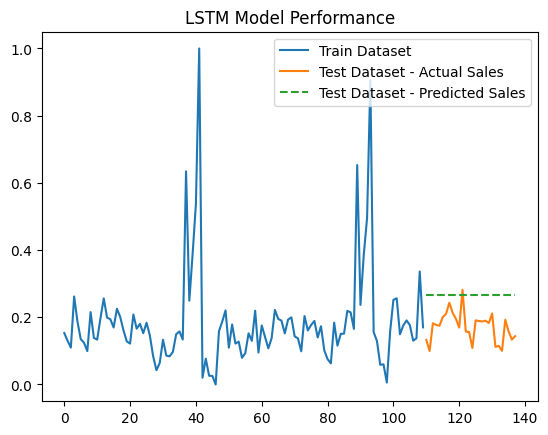

In [52]:
data_y = pd.DataFrame({'true':y_train.squeeze().tolist() + y_test.squeeze().tolist(),
              'predict':y_train.squeeze().tolist() + y_predict.squeeze().tolist(),})

train_index = len(y_train.squeeze().tolist())
test_index = len(y_test.squeeze().tolist())

train, test = data_y.iloc[:train_index], data_y.iloc[train_index:]

plt.plot(train.index, train['true'], label='Train Dataset')
plt.plot(test.index,  test['true'], label='Test Dataset - Actual Sales')
# plt.plot(data_y.index,  data_y['true'], label='Actual')
plt.plot(test.index,  test['predict'], label='Test Dataset - Predicted Sales', linestyle='dashed')
plt.title('LSTM Model Performance')
plt.legend()
plt.show()

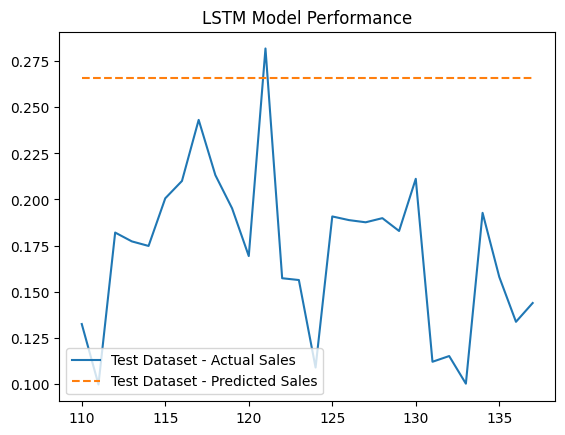

In [53]:
# plt.plot(train.index, train['true'], label='Train Dataset')
plt.plot(test.index,  test['true'], label='Test Dataset - Actual Sales')
# plt.plot(data_y.index,  data_y['true'], label='Actual')
plt.plot(test.index,  test['predict'], label='Test Dataset - Predicted Sales', linestyle='dashed')
plt.title('LSTM Model Performance_Test Period')
plt.legend()
plt.show()

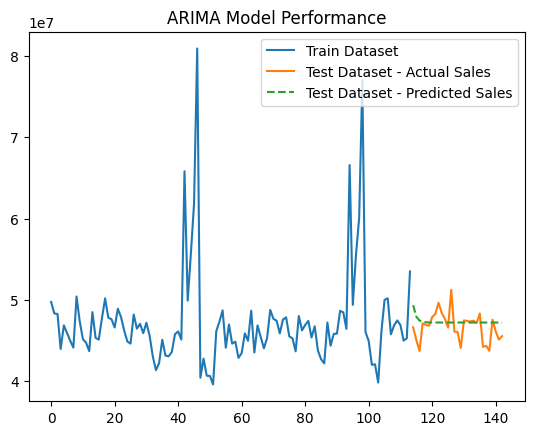

RMSE: 1924110.7080759571


In [54]:
label = feature_params.target_col

df_copy = df[[feature_params.datetime_col,feature_params.target_col]].copy()
df_copy[feature_params.datetime_col] = pd.to_datetime(df_copy[feature_params.datetime_col], dayfirst=True)
time_sales = df_copy.groupby(feature_params.datetime_col).sum().reset_index()
df_new = pd.DataFrame(time_sales[label])

train_size = int(len(df_new) * 0.8)
train, test = df_new.iloc[:train_size], df_new.iloc[train_size:]

order = (1,0,0)
# s_order = (0, 0, 2, 12)
arima_model = ARIMA(train,order=order)
fit_model = arima_model.fit()


predictions = fit_model.forecast(steps=len(test))

plt.plot(train.index, train[label], label='Train Dataset')
plt.plot(test.index,  test[label], label='Test Dataset - Actual Sales')
plt.plot(test.index,  predictions, label='Test Dataset - Predicted Sales', linestyle='dashed')
plt.title('ARIMA Model Performance')
plt.legend()
plt.show()

# # 计算 RMSE（均方根误差）
rmse = np.sqrt(mean_squared_error(test[label], predictions))
print(f'RMSE: {rmse}')